In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.06, factor=0.4, random_state=26)


In [ ]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.39771373  0.01707457]
 [-0.30813836 -0.32489932]
 [ 0.05764162  0.98844968]
 [ 0.2559183  -0.29377242]
 [-0.44363469  0.92569896]]

First 5 y labels:
[1 1 0 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

In [ ]:
# Check different labels
circles.label.value_counts()

In [ ]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
X.shape, X.ndim

In [ ]:
y.shape, y.ndim

In [ ]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=6) # takes in 2 features (X), produces 6 features
        self.layer_2 = nn.Linear(in_features=6, out_features=1) # takes in 6 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

In [ ]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

In [ ]:
y_test[:5]

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.08, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

In [ ]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
# Fit the model
torch.manual_seed(26)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

In [ ]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

In [ ]:
# Visualize the toy tensor
plt.plot(A);

In [ ]:
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

In [ ]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [ ]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

In [ ]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

tensor([[-6.3492,  1.8172],
        [-1.4204, 10.6364],
        [ 2.2323,  1.1060],
        [ 3.4127,  9.1009],
        [-6.4179,  4.4484]]) tensor([1, 6, 8, 9, 3])


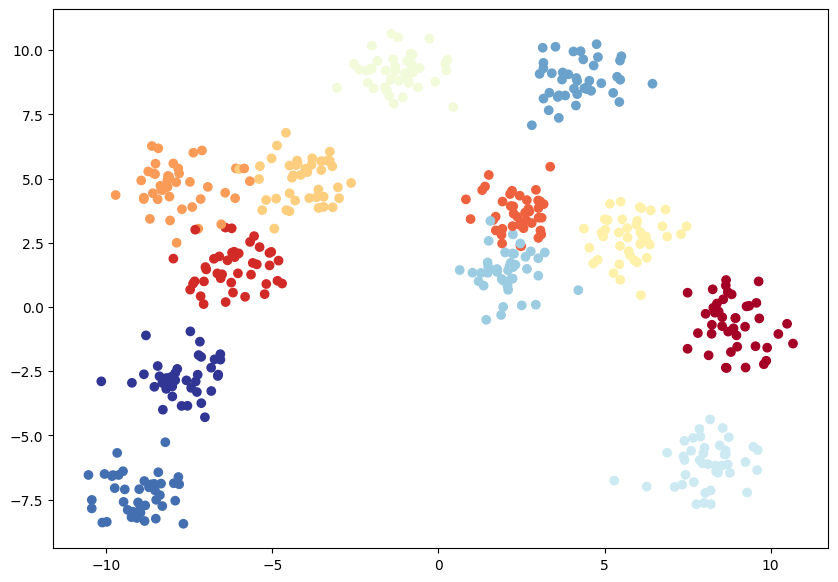

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 12
NUM_FEATURES = 2
RANDOM_SEED = 37

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=500,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=.8,
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.relu = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=12).to(device)
model_4

BlobModel(
  (layer_1): Linear(in_features=2, out_features=12, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=12, out_features=12, bias=True)
  (layer_3): Linear(in_features=12, out_features=12, bias=True)
)

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.01) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [ ]:
# Perform a single forward pass on the data
model_4(X_blob_train.to(device))[:5]

tensor([[-0.2805, -0.2728, -0.2054, -0.3572,  0.0887, -0.7219, -0.3124, -0.6261,
          0.2540,  0.3401, -0.0126,  0.3786],
        [-0.3105, -0.3008, -0.3496, -0.5640,  0.1930, -1.1676, -0.4039, -0.9007,
          0.0797,  0.3483,  0.0029,  0.7949],
        [-0.3183, -0.3048, -0.2081, -0.4045,  0.0975, -0.7845, -0.3287, -0.6774,
          0.2386,  0.3465, -0.0173,  0.4424],
        [-0.1314, -0.0619, -0.2783, -0.2569,  0.0582, -0.4818, -0.1741, -0.5843,
          0.3500,  0.3422,  0.0423,  0.3169],
        [ 0.2879,  0.1006, -0.2702, -0.0087, -0.0795, -0.3598, -0.2790, -0.2420,
          0.2669,  0.2709, -0.1836,  0.0170]], grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([12]), 12)

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3595, -0.3265, -0.3841, -0.6447,  0.2232, -1.3266, -0.4256, -1.0080,
          0.0655,  0.3749, -0.0118,  0.9500],
        [-0.1617, -0.1713, -0.2031, -0.2215,  0.0739, -0.5409, -0.2720, -0.4880,
          0.2602,  0.3095,  0.0172,  0.2168],
        [-0.8635, -0.7440, -0.2329, -0.9967,  0.1556, -1.6074, -0.4989, -1.4217,
          0.3026,  0.5745, -0.1167,  1.3480],
        [-0.5068,  0.0671, -0.6510, -1.2506,  0.1561, -1.1427,  0.2479, -1.5760,
          0.7359,  0.6971, -0.1631,  1.2507],
        [-0.3985, -0.3722, -0.2146, -0.4765,  0.0928, -0.9074, -0.3532, -0.8020,
          0.2921,  0.4104, -0.0299,  0.5954]], grad_fn=<SliceBackward0>)
tensor([[0.0620, 0.0641, 0.0605, 0.0466, 0.1111, 0.0236, 0.0580, 0.0324, 0.0949,
         0.1293, 0.0878, 0.2297],
        [0.0755, 0.0748, 0.0725, 0.0711, 0.0956, 0.0517, 0.0676, 0.0545, 0.1152,
         0.1210, 0.0903, 0.1103],
        [0.0347, 0.0391, 0.0652, 0.0304, 0.0962, 0.0165, 0.0500, 0.0199, 0.1114,
         0.1463, 0.0733, 0.

In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0620, 0.0641, 0.0605, 0.0466, 0.1111, 0.0236, 0.0580, 0.0324, 0.0949,
        0.1293, 0.0878, 0.2297], grad_fn=<SelectBackward0>)
tensor(11)


Epoch: 0 | Loss: 2.85005, Acc: 0.75% | Test Loss: 2.68741, Test Acc: 1.00%
Epoch: 5000 | Loss: 0.13510, Acc: 96.25% | Test Loss: 0.16877, Test Acc: 93.00%
Epoch: 10000 | Loss: 0.08000, Acc: 97.25% | Test Loss: 0.10776, Test Acc: 94.00%
Epoch: 15000 | Loss: 0.05726, Acc: 98.00% | Test Loss: 0.09545, Test Acc: 95.00%
Epoch: 20000 | Loss: 0.04716, Acc: 98.00% | Test Loss: 0.09537, Test Acc: 94.00%
Epoch: 25000 | Loss: 0.04137, Acc: 98.25% | Test Loss: 0.09844, Test Acc: 94.00%
Epoch: 30000 | Loss: 0.03751, Acc: 98.25% | Test Loss: 0.10227, Test Acc: 94.00%
Epoch: 35000 | Loss: 0.03493, Acc: 98.75% | Test Loss: 0.10599, Test Acc: 95.00%
Epoch: 40000 | Loss: 0.03318, Acc: 98.75% | Test Loss: 0.10865, Test Acc: 96.00%
Epoch: 45000 | Loss: 0.03195, Acc: 98.75% | Test Loss: 0.11071, Test Acc: 96.00%


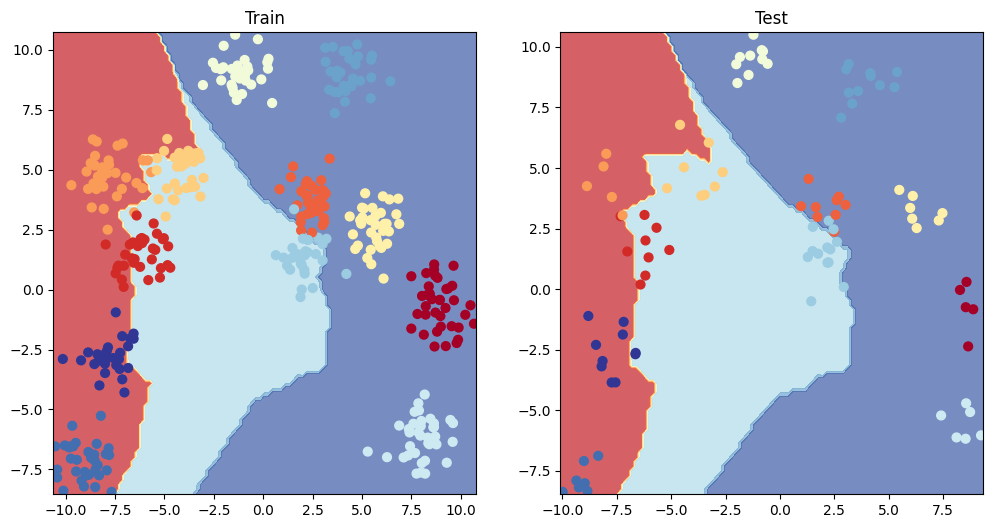

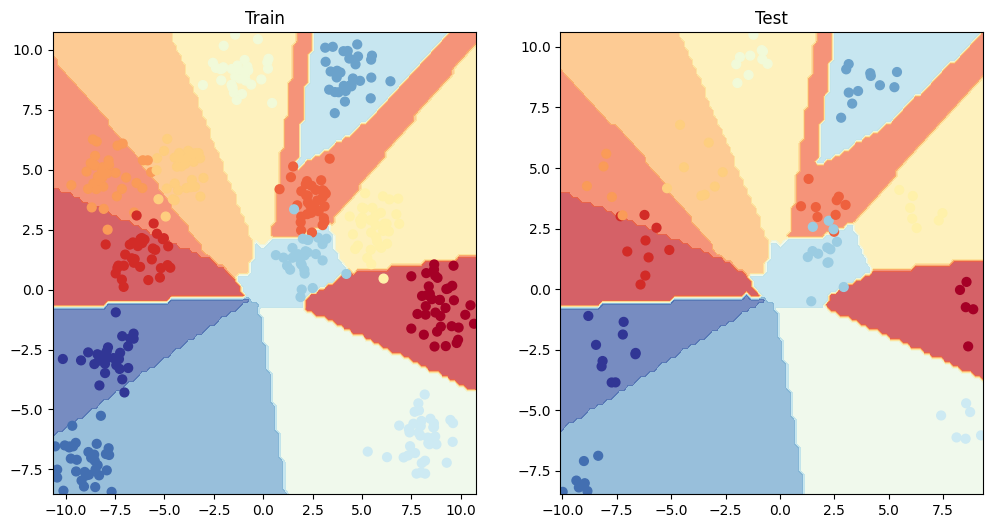

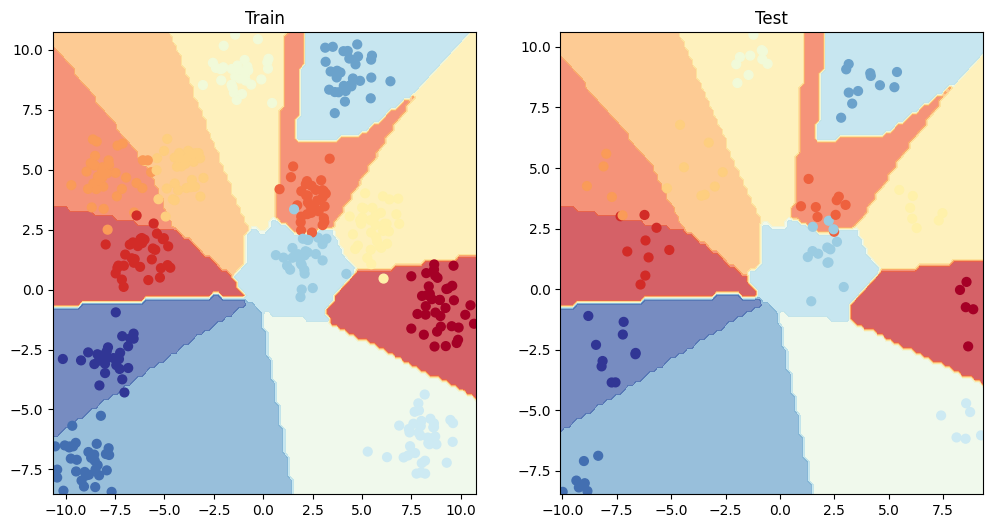

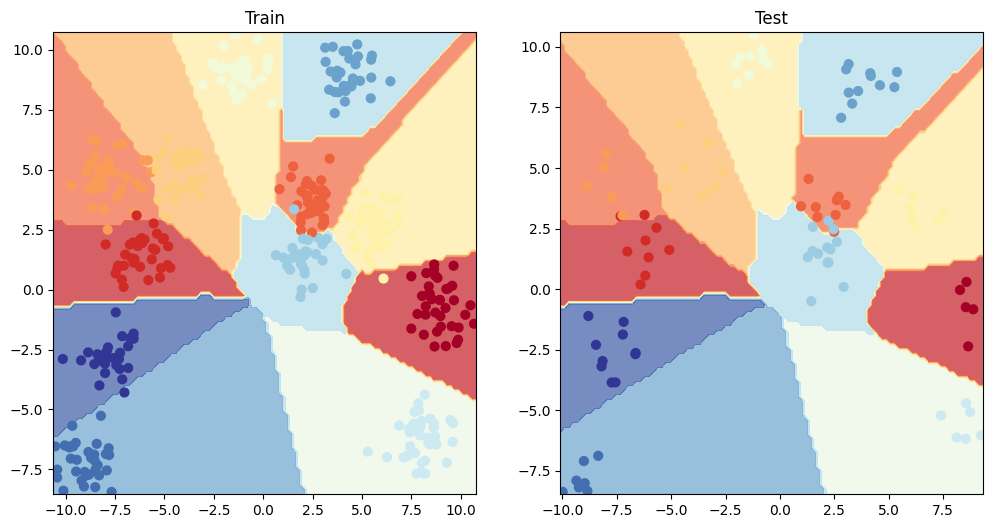

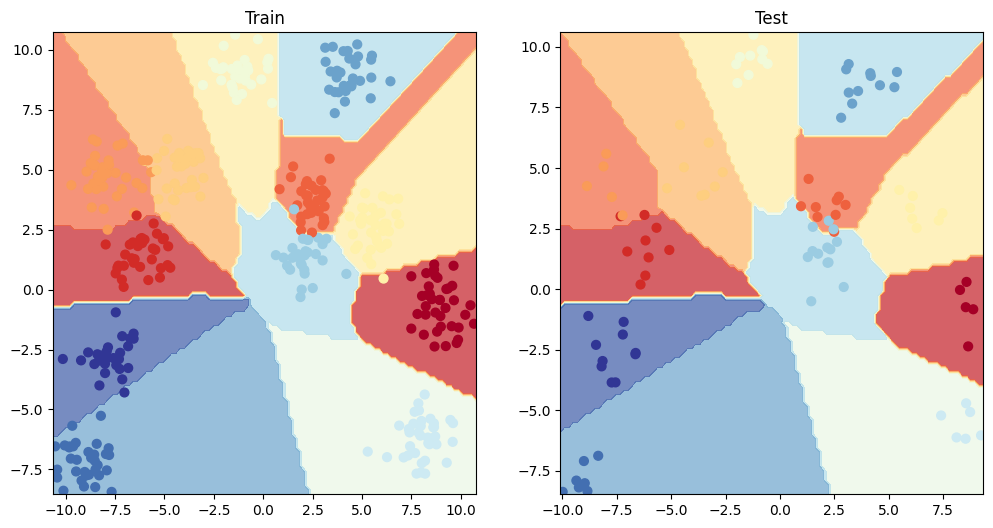

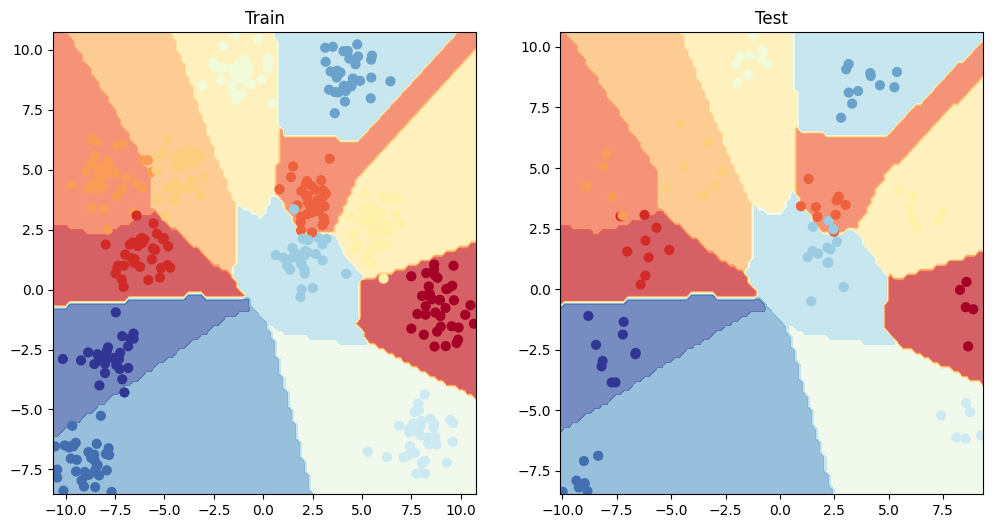

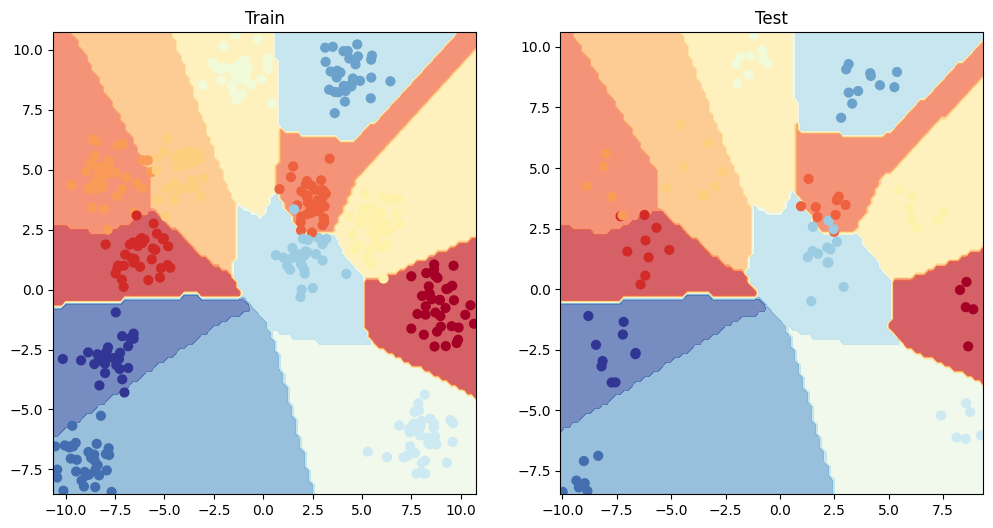

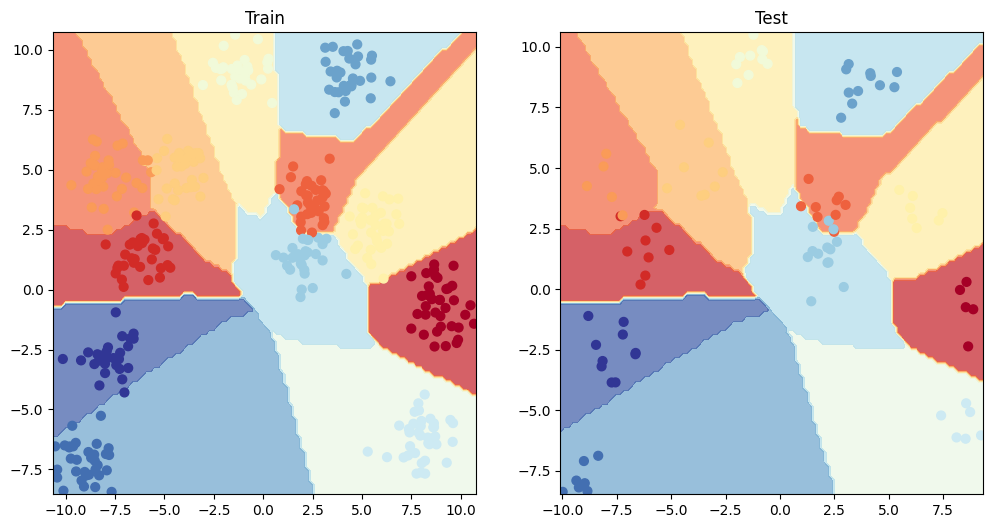

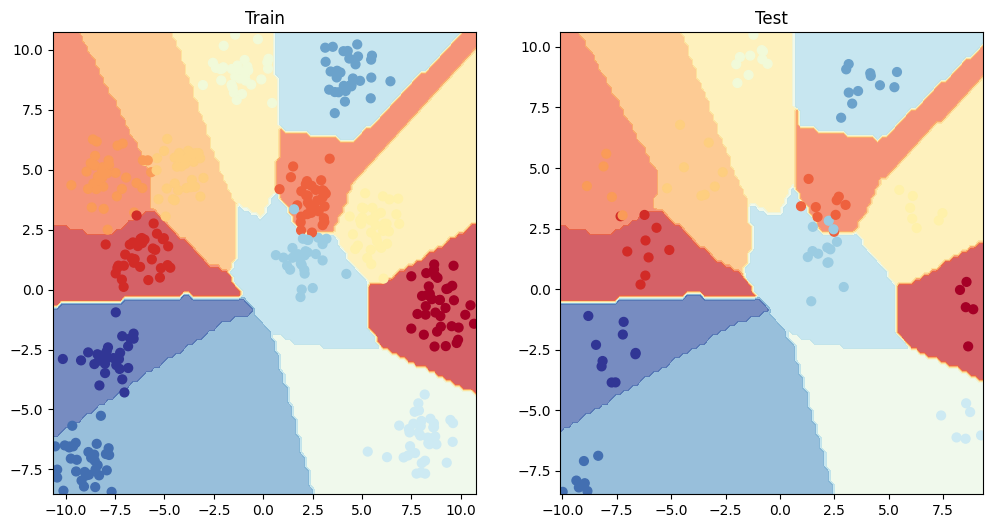

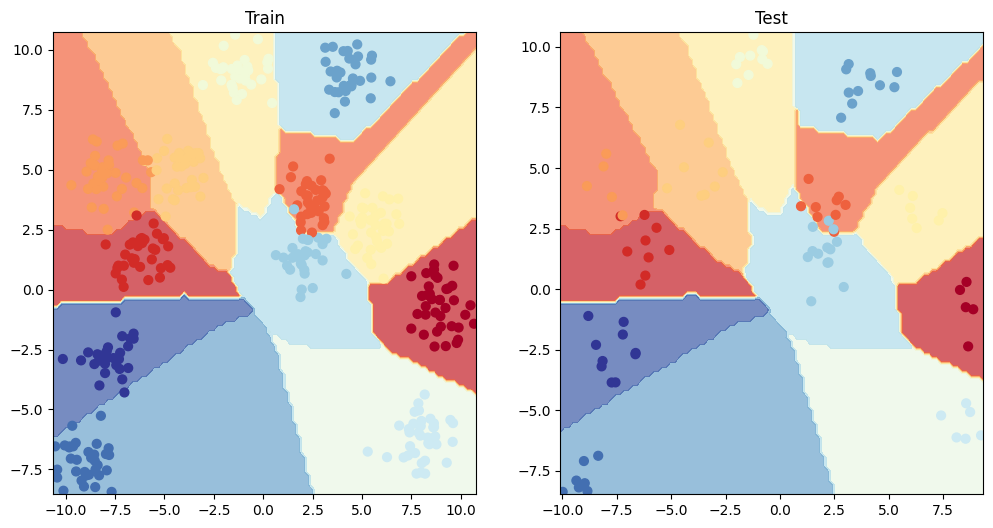

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.01)

# Create a learning rate scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=250, gamma=0.5)

# Fit the model
torch.manual_seed(92)

# Set number of epochs
epochs = 50000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 5000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Train")
        plot_decision_boundary(model_4, X_blob_train, y_blob_train)
        plt.subplot(1, 2, 2)
        plt.title("Test")
        plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-4.1531e+01,  3.3457e+01,  2.9741e+01, -1.7719e+01,  3.1953e+01,
         -6.0511e+01,  5.4949e+01, -3.6565e+01,  3.9916e+01,  1.5195e+01,
         -5.0389e+01,  2.1913e+00],
        [-5.6120e-01, -7.2570e+00,  1.3632e+01, -1.3347e+01, -5.6196e+00,
          4.7443e+00, -2.5412e+00,  5.2330e-01,  2.1210e+01, -6.6009e+00,
         -6.7550e+00, -3.8986e+00],
        [ 1.3815e+01, -3.5201e+01,  5.2376e+01, -6.1816e+01, -4.5824e+01,
          2.8061e+01, -5.2306e+00, -3.4256e+01,  1.3449e+01,  6.0469e+01,
         -1.1878e+01, -8.0595e+00],
        [ 5.7210e+01, -4.1045e+01,  2.9913e+00, -1.8595e+01, -3.4731e+01,
          4.6360e+01, -5.8817e+01,  4.7885e+01,  5.0039e+01, -6.9490e+01,
          2.4247e+01, -7.1338e+00],
        [ 8.9596e+00, -2.1909e+01,  2.7183e+01, -3.1806e+01, -2.4527e+01,
          1.9671e+01, -9.2571e+00, -8.7952e+00,  1.7563e+01,  1.5827e+01,
         -4.6187e+00, -6.0212e+00],
        [ 5.7097e+01, -3.8637e+01, -1.3755e+01, -4.3777e-01, -2.9184e+01,
      

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([ 6,  8,  9,  0,  2,  7, 11,  5, 10,  8])
Labels: tensor([ 6,  8,  9,  0,  2,  7, 11,  5, 10,  8])
Test accuracy: 96.0%


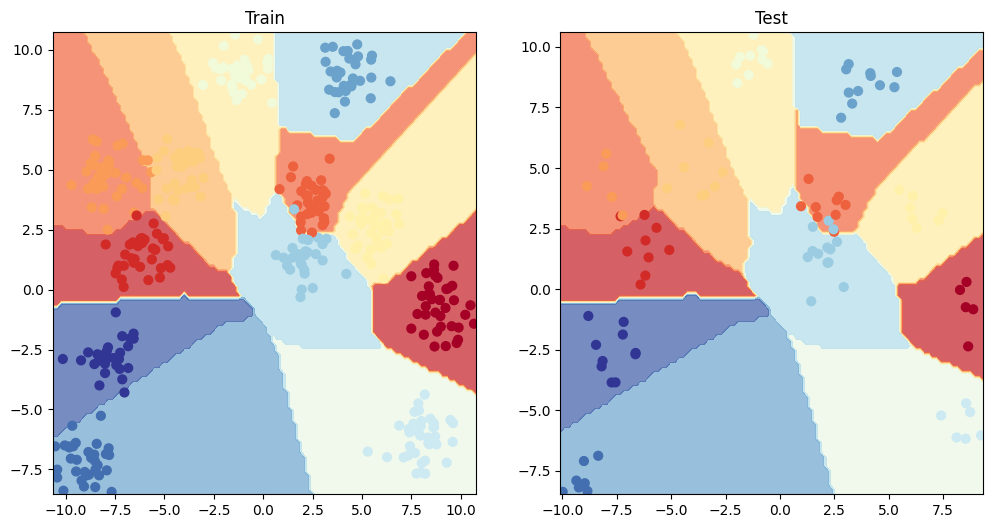

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=12).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9600)